In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares
import powerlaw
from scipy.optimize import curve_fit
from collections import Counter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial
growth_rates = {1: 0.003, 2: 0.001, 3: 0.0014}  
num_iterations = 30  # Number of iterations

# Initialize the grid and counts

counts = {0: grid_size * grid_size, 1: 0, 2: 0, 3: 0}

def initial_land_use(seed_number, grid_size, plot=True):
    np.random.seed(seed_number)
    
    grid = np.zeros((grid_size, grid_size), dtype=int)

    # Define initial conditions
    center_x, center_y = grid_size // 2, grid_size // 2
    
    # Randomly select positions for commercial cells
    commercial_cells = []
    num_commercial = 3
    min_dist_commercial = 1  # Minimum distance from center
    
    while len(commercial_cells) < num_commercial:
        x = np.random.randint(center_x - min_dist_commercial, center_x + min_dist_commercial + 1)
        y = np.random.randint(center_y - min_dist_commercial, center_y + min_dist_commercial + 1)
        if (x, y) not in commercial_cells:
            commercial_cells.append((x, y))

    residential_cells = []
    num_residential = 25
    min_dist = 3  # Minimum distance from commercial cells

    industrial_cells = []
    num_industrial = 4
    min_dist_industrial = 3  # Minimum distance from commercial cells

    # Generate random residential cells around the commercial area
    while len(residential_cells) < num_residential:
        x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
        y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
        if (x, y) not in commercial_cells:
            residential_cells.append((x, y))

    # Generate random industrial cells around the commercial area
    while len(industrial_cells) < num_industrial:
        x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
        y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
        if (x, y) not in commercial_cells:
            industrial_cells.append((x, y))

    # Assign initial land use types
    for x, y in commercial_cells:
        grid[x, y] = states['C']  # Commercial
    for x, y in residential_cells:
        grid[x, y] = states['H']  # Residential
    for x, y in industrial_cells:
        grid[x, y] = states['I']  # Industrial

    if plot:
        # Set the figure size
        plt.figure(figsize=(8, 8))
        cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
        plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        plt.title('Initial Land Use')
        plt.show()

    return grid



In [3]:
weights_table = {
    'Vacant_Commerce': {
        'C': [6, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'I': [0]*18,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Vacant_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Vacant_Housing': {
        'C': [-2, -1, 2, 1, 1, 1, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [2, 2, 1.5, 1.5, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
        'V': [0]*18
    },
    'Industry_Commerce': {
        'C': [25, 15, 10, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-2, -2, -2] + [0]*15,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Industry_Industry': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Industry_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
    'Housing_Commerce': {
        'C': [25, 15, 10, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        'I': [-10, -10, -5, -3, -1] + [0]*13,
        'H': [4, 3.5, 3, 2.5, 2, 2, 2, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1],
        'V': [0]*18
    },
    'Housing_Industry': {
        'C': [0]*18,
        'I': [3, 3, 2, 1, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        'H': [-1, -1, 0] + [0]*15,
        'V': [0]*18
    },
    'Housing_Housing': {
        'C': [0]*18,
        'I': [0]*18,
        'H': [0]*18,
        'V': [0]*18
    },
}

# Test of accessing a weight:
transition = 'Vacant_Commerce'
cell_type = 'H'
distance_zone = 1
# This is distance zone is from 0 to 17
weight = weights_table[transition][cell_type][distance_zone]
print(f"The weight for transition={transition}, cell_type={cell_type}, distance_zone={distance_zone} is {weight}")


The weight for transition=Vacant_Commerce, cell_type=H, distance_zone=1 is 3.5


In [4]:

def get_distance_zone(distance):
    zone_mapping = {0: 1, 1: 1.4, 2: 2, 3: 2.2, 4: 2.8, 5: 3, 6: 3.2, 7: 3.6, 8: 4, 9: 4.1, 10: 4.2, 11: 4.5, 12: 5, 13: 5.1, 14: 5.4, 15: 5.7, 16: 5.8, 17: 6}
    for zone, max_distance in reversed(list(zone_mapping.items())):
        if distance >= max_distance:
            return zone
    return 0  # Return 0 if distance is less than the minimum specified distance

def get_neighbourhood(grid, row, col, radius):
    rows, cols = grid.shape
    square_row_range = range(max(0, row - radius), min(rows, row + radius + 1))
    square_col_range = range(max(0, col - radius), min(cols, col + radius + 1))
    square_neighbourhood = grid[np.ix_(square_row_range, square_col_range)]
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    distance_zones = np.zeros_like(square_neighbourhood, dtype=int)
    # Adjusted center coordinates inside the neighbourhood
    center = min(row, radius), min(col, radius)
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            distance = np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2)
            if distance <= radius:
                circle_mask[i, j] = True
                distance_zones[i, j] = get_distance_zone(distance)
    circle_mask[center] = False  # Exclude the center cell
    return square_neighbourhood[circle_mask], distance_zones[circle_mask]




def cell_type_to_states(state):
    if state == 'Vacant':
        return 0
    elif state == 'Housing':
        return 1
    elif state == 'Industry':
        return 2
    elif state == 'Commerce':
        return 3

def states_to_cell_type(state):
    if state == 0:
        return 'V'
    elif state == 1:
        return 'H'
    elif state == 2:
        return 'I'
    elif state == 3:
        return 'C'


def calculate_transition_potentials(grid, alpha, weights_table, radius):
    transition_potentials = np.zeros((grid.shape[0], grid.shape[1], 4))  # 4 possible states
    transitions = ['Vacant_Commerce', 'Vacant_Industry', 'Vacant_Housing', 'Industry_Commerce', 'Industry_Industry',
                   'Industry_Housing', 'Housing_Commerce', 'Housing_Industry', 'Housing_Housing']
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            neighbourhood, distance_zones = get_neighbourhood(grid, i, j, radius)
            for transition in transitions:
                # Extract the current state and desired state from the transition string
                current_state, desired_state = transition.split('_')
                
                current_state_num = cell_type_to_states(current_state)
                desired_state_num = cell_type_to_states(desired_state)
                
            
                if grid[i, j] == current_state_num:
                    sum_weights = 0
                    for neighbor_state, distance_zone in zip(neighbourhood, distance_zones):
                        
                        neighbor_type = states_to_cell_type(neighbor_state)
                        
                        m_kd = weights_table[transition][neighbor_type][distance_zone]

                        if neighbor_state == desired_state_num:
                            sum_weights += m_kd

                    
                    R = np.random.uniform(0, 1)
                    S = 1 + (-math.log(R))**alpha
                    transition_potentials[i, j, desired_state_num] = S * (1 + sum_weights)
    return transition_potentials







In [5]:
test_grid = np.array([
    [3, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 2, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
])


alpha = 1

transition_potentials_test = calculate_transition_potentials(test_grid, alpha, weights_table, 2)
print("Transition Potentials:")
print(transition_potentials_test)




Transition Potentials:
[[[ 0.          0.          0.          0.        ]
  [ 0.         22.63013499  1.02977137 11.16546024]
  [ 0.          9.71931537  3.63686369  5.45980392]
  [ 0.         13.05895791  1.26887499  3.63781328]
  [ 0.          4.7057408   2.69914302  1.40374966]]

 [[ 0.          8.85102844  1.83567302 15.03050649]
  [ 0.          1.03966477  6.15294196 62.39778042]
  [ 0.          1.57998544  6.32123907  1.13746053]
  [ 0.          1.66921756  6.10443466  1.55500874]
  [ 0.         22.95241546  1.77587303  3.24728003]]

 [[ 0.         12.07297433  4.64039677 14.34058937]
  [ 0.          2.41189247  6.6383884   3.22994538]
  [ 0.          2.12796843  4.10546475  2.95399843]
  [ 0.          1.46088835  6.54256363  3.73696895]
  [ 0.         18.69358204  4.39779943  2.86306131]]

 [[ 0.          9.18311404  2.19965033  1.48672905]
  [ 0.          1.52071362  7.99028072  1.2486464 ]
  [ 0.          2.36461435  7.68606921  2.14303996]
  [ 0.          1.30849092  5.95327

In [133]:
def run_simulation(grid, weights_table, alpha, growth_rates, radius, seed, num_iterations, plot = False):
    np.random.seed(seed)
    grid_size = grid.shape[0]
    # initialize the arrays to keep track of
    powlaw_vals = np.zeros([num_iterations, 13])

    for iteration in range(num_iterations):
        transition_potentials = calculate_transition_potentials(grid, alpha, weights_table, radius)

        highest_potentials = {}
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == states['V']:
                    potential_states = ['H', 'I', 'C']
                elif grid[i, j] == states['H']:
                    potential_states = ['I', 'C']
                elif grid[i, j] == states['I']:
                    potential_states = ['C']
                else:
                    potential_states = []
                    
                if potential_states:
                    highest_potentials[(i, j)] = max(potential_states, key=lambda state: transition_potentials[i, j, states[state]])

        for new_state_key in sorted(states, key=lambda k: states[k], reverse=True):
            new_state = states[new_state_key]
            if new_state_key != 'V':
                num_to_convert = int(grid_size * grid_size * growth_rates[new_state_key])
                potential_cells = [(i, j) for i, j in highest_potentials.keys() if highest_potentials[(i, j)] == new_state_key]
                potential_cells.sort(key=lambda cell: transition_potentials[cell[0], cell[1], states[highest_potentials[cell]]], reverse=True)
                
                for cell in potential_cells[:num_to_convert]:
                    grid[cell] = new_state

        # This is where you run and append the powlaw vals
        clusters = run_clustering(grid)
        powlaw = tests_power_law(clusters)
        powlaw_vals[iteration] = powlaw
        
    if plot:
        plt.figure(figsize=(10, 10))
        cmap = plt.cm.colors.ListedColormap(['white', 'skyblue', 'grey', 'orange'])
        plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
        plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
        plt.title('Final Land Use')
        plt.show()

    return grid, powlaw_vals


In [134]:
def run_sim_time_plot(growth_rates, grid_size, sims, num_iterations):
    """
    Function is for running multiple sims with same params and storing results.
    """
    # Here are the arrays to track the results. 
    powlaw_array = np.zeros([sims, num_iterations, 13])
    end_grids = np.zeros([sims, grid_size, grid_size])
    # Then loop through nr. of sims and store results.
    for sim in range(sims):
        rn = np.random.randint(0, 100000, 1)
        grid = initial_land_use(seed_number=rn, grid_size=grid_size, plot=False)
        final_grid, power_fit = run_simulation(grid, weights_table, alpha=2.5, growth_rates=growth_rates, radius = 6, seed=rn, num_iterations=num_iterations, plot=False)
        
        end_grids[sim] = final_grid
        powlaw_array[sim] = power_fit
    return end_grids, powlaw_array

growth_rates = {
    'H': 0.01,  
    'I': 0.002,
    'C': 0.001,
}
grid_size = 100
sims, num_iterations = 5, 40
end_grids, powlaw_array = run_sim_time_plot(growth_rates, grid_size, sims, num_iterations)


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


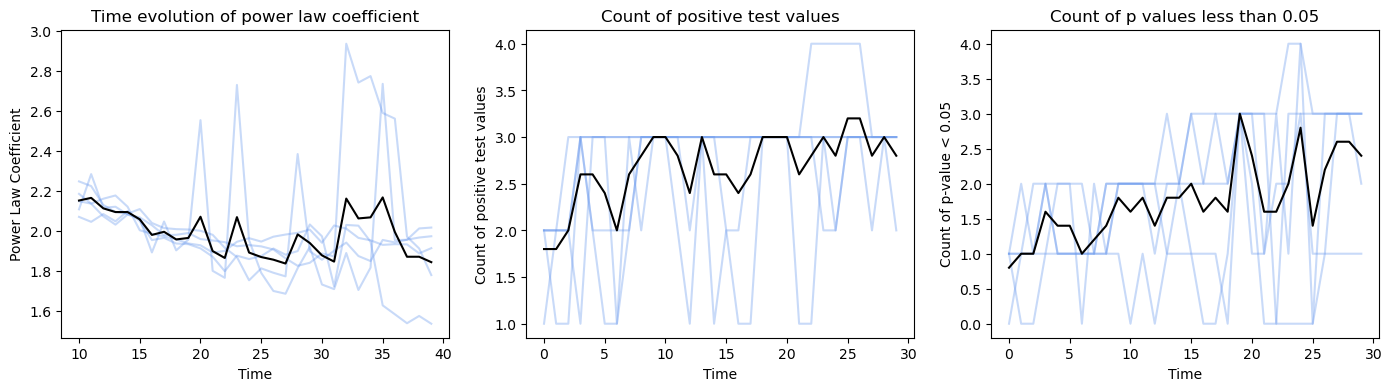

In [137]:
plot_mean = np.mean(powlaw_array[:,:,0], axis = 0)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 4))
true_count = np.sum(np.where(powlaw_array[:,:,[1,3,5,7,9]] > 0, 1, 0), axis = 2)

for time in range(sims):
    ax1.plot(range(10,40), powlaw_array[time,10:,0], alpha = 0.35, c = 'cornflowerblue') # power law coef
    ax2.plot(true_count[time,10:], alpha = 0.35, c = 'cornflowerblue') # count of passed tests
    ax3.plot(powlaw_array[time,10:,-1], alpha = 0.35, c = 'cornflowerblue') # p-vals passed
    
ax1.plot(range(10,40), plot_mean[10:], c = 'black')
ax2.plot(np.mean(true_count, axis = 0)[10:], c = 'black')
ax3.plot(np.mean(powlaw_array[:,:,-1], axis = 0)[10:], c = 'black')

ax1.set_xlabel('Time'), ax1.set_ylabel('Power Law Coefficient')
ax2.set_xlabel('Time'), ax2.set_ylabel('Count of positive test values')
ax3.set_xlabel('Time'), ax3.set_ylabel('Count of p-value < 0.05')
ax1.set_title('Time evolution of power law coefficient')
ax2.set_title('Count of positive test values')
ax3.set_title('Count of p values less than 0.05')
plt.savefig('test.jpg')
plt.show()


In [164]:
x = run_clustering(end_grids[0])
xx = x[x.cell_type == 1]
y = tests_power_law(xx)
y

Calculating best minimal value for power law fit


Assuming nested distributions
/Users/andu/opt/anaconda3/lib/python3.9/site-packages/powerlaw.py:1570: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm


[2.0157134570801127,
 3.873602625380211,
 0.00010723821787974416,
 3.33631264736551,
 0.03201106751992414,
 -0.15679764597729395,
 0.5754823049605126,
 -8.111900790254904,
 0.26981628550230186,
 18.90764058824566,
 0.00012783013359084328,
 3,
 3]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


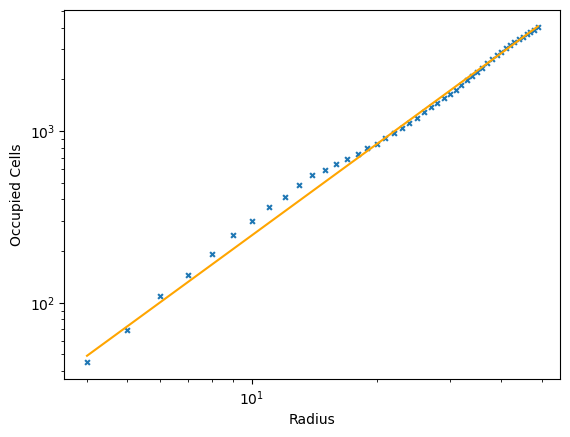

1.763378355604341

In [171]:
run_fractal_analysis(end_grids[0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [130]:
import pickle

with open(r"powlaw_array.pkl", "wb") as output_file:
    pickle.dump(powlaw_array, output_file)

In [161]:
print(pd.DataFrame(powlaw_array[:,-1,[1,3,5,7,9]]))
print(pd.DataFrame(powlaw_array[:,-1,[2,4,6,8,10]]))

          0         1         2         3          4
0  3.873603  3.336313 -0.156798 -8.111901  18.907641
1  3.732411  3.084382 -0.131204 -8.024333  16.060567
2  3.152265 -0.063082 -0.353339 -0.058572   0.158229
3  3.959362  1.561134 -0.025938 -7.831471   6.105026
4  4.089920  2.369749 -0.093783 -7.935654  13.321460
          0         1         2         3         4
0  0.000107  0.032011  0.575482  0.269816  0.000128
1  0.000190  0.033032  0.608471  0.282169  0.000704
2  0.001620  0.868130  0.400549  0.782952  0.820910
3  0.000075  0.021832  0.819829  0.303944  0.002063
4  0.000043  0.069660  0.664951  0.290471  0.001306


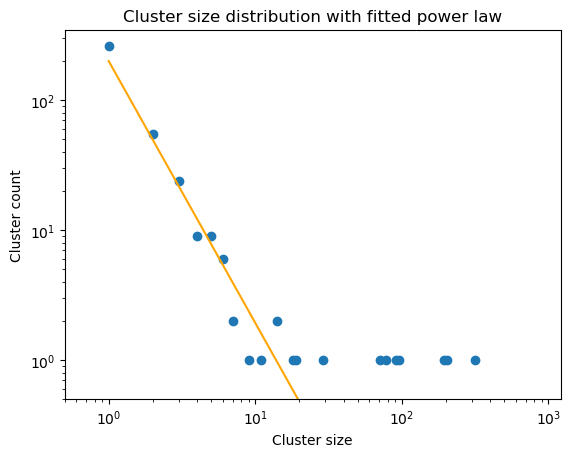

In [167]:
plt.scatter(xx.Cluster_size, xx.Cluster_count)
plt.plot(xx.Cluster_size, 200 * xx.Cluster_size ** -y[0], c = 'orange')
plt.xlim(0.5, 1210) 
plt.ylim(0.5, 350)
plt.yscale('log'), plt.xscale('log')
plt.xlabel('Cluster size'), plt.ylabel('Cluster count')
plt.title('Cluster size distribution with fitted power law')
plt.savefig('power_law_fit.jpg')
plt.show()

## --- The below cell is just for testing the function, you can just jump to the next cell and run it. 

In [132]:
def tests_power_law(clusters):
    """
    Test the power law against alternative distributions and run p-value. 
    """
    # Create the list
    clusters = clusters[clusters.cell_type == 1]
    cluster_list = []
    # rearrange data for powerlaw package functions
    for index, row in clusters.iterrows():
        for c in range(int(row.Cluster_count)):
            cluster_list.append(row.Cluster_size)
    # run all the different tests
    fit = powerlaw.Fit(cluster_list, discrete=True)
    alpha = fit.power_law.alpha
    t1, t11 = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    t2, t21 = fit.distribution_compare('power_law', 'stretched_exponential')
    t3, t31 = fit.distribution_compare('power_law', 'truncated_power_law')
    t4, t41 = fit.distribution_compare('power_law', 'lognormal')
    t5, t51 = fit.distribution_compare('power_law', 'lognormal_positive')
    test_count = np.sum(np.where(np.array([t1, t2, t3, t4, t5]) > 0, 1, 0))
    pval_count = np.sum(np.where(np.array([t11, t21, t31, t41, t51]) < 0.05, 1, 0))
    return [alpha, t1, t11, t2, t21, t3, t31, t4, t41, t5, t51, test_count, pval_count] 

In [7]:
def calculate_joint_probability(ca_grid):
    joint_counts = np.zeros((4, 4))  # 4x4 matrix to store joint counts
    height, width = ca_grid.shape

    # Count the occurrences of pairs of states in the CA grid
    for i in range(height):
        for j in range(width):
            if i < height - 1:
                x = ca_grid[i, j]
                y = ca_grid[i + 1, j]
                joint_counts[x, y] += 1
            if j < width - 1:
                x = ca_grid[i, j]
                y = ca_grid[i, j + 1]
                joint_counts[x, y] += 1

    # Compute joint probabilities by dividing by the total number of pairs
    joint_probabilities = joint_counts / (height * width)
    return joint_probabilities

def calculate_conditional_probability(joint_probabilities):
    marginal_probabilities = np.sum(joint_probabilities, axis=1)
    conditional_probabilities = joint_probabilities / marginal_probabilities[:, np.newaxis]
    return conditional_probabilities

def calculate_conditional_entropy(conditional_probabilities):
    conditional_entropy = -np.sum(conditional_probabilities * np.log2(conditional_probabilities))
    return conditional_entropy

def run_simulation_and_compute_entropy(growth_rate_values_H, growth_rate_values_I, growth_rate_values_C, alpha_values, seed=0, grid_size=50, radius=6, num_iterations=40, export_csv=False, plot=False):
    entropy_results = []
    for alpha in alpha_values:
        for growth_rate_H in growth_rate_values_H:
            for growth_rate_I in growth_rate_values_I:
                for growth_rate_C in growth_rate_values_C:
                    growth_rates = {
                        'H': growth_rate_H,
                        'I': growth_rate_I,
                        'C': growth_rate_C,
                    }
                    grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=plot)
                    run_simulation(grid, weights_table, alpha=alpha, growth_rates=growth_rates, radius=radius, seed=seed, num_iterations=num_iterations)
                    joint_probs = calculate_joint_probability(grid)
                    conditional_probs = calculate_conditional_probability(joint_probs)
                    conditional_entropy = calculate_conditional_entropy(conditional_probs)
                    entropy_results.append((alpha, conditional_entropy))
                    print(f"Alpha: {alpha}, Conditional Entropy: {conditional_entropy}")

    # Plot the results
    alphas, entropies = zip(*entropy_results)
    plt.plot(alphas, entropies, 'o-')
    plt.xlabel('Alpha')
    plt.ylabel('Conditional Entropy')
    plt.show()

# Example usage:
alpha_values = [2.0, 2.5, 3.0]
growth_rate_values_H = [0.01]
growth_rate_values_I = [0.002]
growth_rate_values_C = [0.001]
#run_simulation_and_compute_entropy(growth_rate_values_H, growth_rate_values_I, growth_rate_values_C, alpha_values)


# Functions 

In [8]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)

    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters


def power_law(x, a, b):
    return a*np.power(x, b)

def fractal_dimension(m):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    center = m.shape[0] // 2
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    m = np.where(m > 0, 1, 0)
    
    radius = np.array(range(1, center)) # sets the range to loop over for occupancy
    occupied_cells = np.zeros(center - 1)
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((center - i) ** 2 + (center - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.

    for r in range(len(radius)): # loop through radiuses and chekc which ones are within area and then count cells occupied.
        current_distance = np.where(distance < radius[r], 1, 0)
        
        area = (current_distance * m).sum()
        occupied_cells[r] = area
        
    pars, cov = curve_fit(f=power_law, xdata=radius, ydata=occupied_cells, p0=[0, 0]) # gives higher weight to large values
    fractal_d = np.polyfit(np.log(radius), np.log(occupied_cells), 1) # gives higher weight to small values
    return fractal_d, occupied_cells, radius, pars


def conditional_entropy(grid):
    counter = Counter()
    total_count = 0

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            state = grid[i, j]
            counter[state] += 1
            total_count += 1

    conditional_entropy = 0
    for state, count in counter.items():
        probability = count / total_count
        conditional_entropy -= probability * np.log2(probability)

    return conditional_entropy


## Run the code in below cell optionally to test your functions

In [170]:

def run_fractal_analysis(grid):
    fractal_d, occupied_cells, radius, pars = fractal_dimension(grid)

    plt.scatter(radius[3:], occupied_cells[3:], s = 12, marker = 'x')
    #plt.plot(radius, np.exp(fractal_d[1]) + radius ** fractal_d[0], c = 'orange')
    plt.plot(radius[3:], pars[0] * radius[3:] ** pars[1], c = 'orange')
    plt.xlabel('Radius'), plt.ylabel('Occupied Cells')
    plt.yscale('log'), plt.xscale('log')
    plt.savefig('fractal_dim_fig.jpg')
    plt.show()
    return pars[1]
    
    
    
#run_fractal_analysis(final_grid)

### Conditional Entropy --- Moore Neighborhood

In [10]:
def calculate_joint_counts(grid):
    # Initialize a dictionary to store the joint counts
    joint_counts = {}

    # Loop over each cell in the grid
    for i in range(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            # Get the state of the cell and its neighbors
            state_vector = tuple(grid[i-1:i+2, j-1:j+2].flatten())

            # Increment the count for this state vector
            if state_vector in joint_counts:
                joint_counts[state_vector] += 1
            else:
                joint_counts[state_vector] = 1

    return joint_counts

def calculate_conditional_entropy_Moore(grid):
    # Calculate the joint counts
    joint_counts = calculate_joint_counts(grid)

    # Calculate the joint probabilities
    total_counts = sum(joint_counts.values())
    joint_probabilities = {state_vector: count / total_counts for state_vector, count in joint_counts.items()}

    # Calculate the marginal probabilities
    marginal_probabilities = {}
    for state_vector, joint_probability in joint_probabilities.items():
        cell_state = state_vector[4]  # The cell's state is at the center of the state vector
        if cell_state in marginal_probabilities:
            marginal_probabilities[cell_state] += joint_probability
        else:
            marginal_probabilities[cell_state] = joint_probability

    # Calculate the conditional probabilities and the conditional entropy
    conditional_entropy = 0
    for state_vector, joint_probability in joint_probabilities.items():
        cell_state = state_vector[4]
        conditional_probability = joint_probability / marginal_probabilities[cell_state]
        conditional_entropy -= conditional_probability * np.log2(conditional_probability)

    return conditional_entropy

#print('The conditional entropy is:', calculate_conditional_entropy_Moore(final_grid), 'for final grid with size', final_grid.shape[0], 'x', final_grid.shape[1])



### Conditional Entropy --- Neumann Neighborhood

In [11]:
import numpy as np

def calculate_conditional_entropy_Neumann(grid):
    grid_size = grid.shape[0]
    
    # Initialize joint counts
    joint_counts = np.zeros((4, 4, 4, 4, 4))

    # Count joint occurrences of states
    for i in range(1, grid_size - 1):
        for j in range(1, grid_size - 1):
            cell_state = int(grid[i, j])
            north_state = int(grid[i - 1, j])
            east_state = int(grid[i, j + 1])
            south_state = int(grid[i + 1, j])
            west_state = int(grid[i, j - 1])
            joint_counts[cell_state, north_state, east_state, south_state, west_state] += 1

    # Compute joint probabilities
    joint_probabilities = joint_counts / np.sum(joint_counts)

    # Compute conditional probabilities
    marginal_probabilities = np.sum(joint_probabilities, axis=(1, 2, 3, 4))
    conditional_probabilities = joint_probabilities / marginal_probabilities[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]

    # Compute conditional entropy
    conditional_entropy = -np.nansum(conditional_probabilities * np.log2(conditional_probabilities))
    
    return conditional_entropy

# Use the function
#conditional_entropy = calculate_conditional_entropy(final_grid)
#print("Conditional Entropy:", conditional_entropy)


## ------------------------------ Start Storing Data--------------------------------

In [12]:
def run_simulation_with_clustering(seed, grid_size, alpha, growth_rates, radius, num_iterations):
    # Run the simulation
    grid = initial_land_use(seed_number=seed, grid_size=grid_size, plot=False)
    final_grid = run_simulation(grid, weights_table, alpha=alpha, growth_rates=growth_rates, radius=radius, seed=seed, num_iterations=num_iterations)

    # Compute cluster sizes
    clusters = run_clustering(final_grid)
    clusters['growth_rate_H'] = growth_rates['H']
    clusters['growth_rate_I'] = growth_rates['I']
    clusters['growth_rate_C'] = growth_rates['C']
    clusters['seed'] = seed
    clusters['alpha'] = alpha
    return clusters, final_grid




def run_multiple_simulations(params):
    all_clusters = pd.DataFrame()
    num_total_simulations = (
        len(params['growth_rate_values_H'])
        * len(params['growth_rate_values_I'])
        * len(params['growth_rate_values_C'])
        * len(params['alpha_values'])
    )
    current_simulation = 0

    for growth_rate_H in params['growth_rate_values_H']:
        for growth_rate_I in params['growth_rate_values_I']:
            for growth_rate_C in params['growth_rate_values_C']:
                for alpha in params['alpha_values']:
                    growth_rates = {'H': growth_rate_H, 'I': growth_rate_I, 'C': growth_rate_C}
                    clusters, final_grid = run_simulation_with_clustering(params['seed'], params['grid_size'], alpha, growth_rates, params['radius'], params['num_iterations'])
                    
                    # Compute conditional entropy
                    condi_entropy = calculate_conditional_entropy_Moore(final_grid)
                    
                    # Compute fractal dimension
                    fractal_d, _, _, _ = fractal_dimension(final_grid)
                    
                    # Add conditional entropy and fractal dimension to the DataFrame
                    clusters['conditional_entropy'] = pd.Series([condi_entropy]*len(clusters), index=clusters.index)
                    clusters['fractal_dimension'] = pd.Series([fractal_d[0]]*len(clusters), index=clusters.index)

                    all_clusters = pd.concat([all_clusters, clusters])

                    # Update and print the overall progress
                    current_simulation += 1
                    percentage_done = (current_simulation / num_total_simulations) * 100
                    print(f"\rOverall progress: {percentage_done:.2f}%", end='')

    print("\nSimulation completed!")
      
    if params['export_csv']:
        all_clusters.to_csv('CA_simulation_data.csv', index=False)
        
    if params['plot']:
        for land_use_type in all_clusters['cell_type'].unique():
            cluster_sizes = all_clusters[all_clusters['cell_type'] == land_use_type]['Cluster_size']
            cluster_counts = all_clusters[all_clusters['cell_type'] == land_use_type]['Cluster_count']
            plt.scatter(cluster_sizes, cluster_counts)
            plt.yscale('log')
            plt.xscale('log')
            plt.title(f'Cluster Sizes for Land Use Type {land_use_type}')
            plt.xlabel('Cluster Size')
            plt.ylabel('Frequency')
            plt.show()
            
    return all_clusters


params = {
    'growth_rate_values_H': [0.01],
    'growth_rate_values_I': [0.003],
    'growth_rate_values_C': [0.0013]  , # adjust this  [0.0013, 0.00136, 0.00142, 0.00148, 0.00154]
    'alpha_values': [1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.625, 3.75, 3.875, 4.0], # change this to the string as shown in the Whatapp chat
    'seed': 4, # change this number, for whatever you like (@ v @ ~). 
    'grid_size': 75,
    'radius': 6,
    'num_iterations': 50,
    'export_csv': True,
    'plot': False
}

all_clusters = run_multiple_simulations(params)


Initial counts: {0: 5599, 1: 19, 2: 4, 3: 3}
Final counts: {0: 2062, 1: 2423, 2: 787, 3: 353}
Overall progress: 4.00%Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Initial counts: {0: 5599, 1: 19, 2: 4, 3: 3}
Final counts: {0: 1996, 1: 2502, 2: 774, 3: 353}
Overall progress: 8.00%Initial counts: {0: 5599, 1: 19, 2: 4, 3: 3}
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Final counts: {0: 1960, 1: 2537, 2: 775, 3: 353}
Overall progress: 12.00%Initial counts: {0: 5599, 1: 19, 2: 4, 3: 3}
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only pro

In [14]:
all_clusters

,Cluster_size,Cluster_count,cell_type,growth_rate_H,growth_rate_I,growth_rate_C,seed,alpha,conditional_entropy,fractal_dimension
0,1.0,16.0,1.0,0.01,0.003,0.0013,4,1.0,10.721076,2.135918
1,2.0,1.0,1.0,0.01,0.003,0.0013,4,1.0,10.721076,2.135918
2,242.0,1.0,1.0,0.01,0.003,0.0013,4,1.0,10.721076,2.135918
3,2163.0,1.0,1.0,0.01,0.003,0.0013,4,1.0,10.721076,2.135918
0,1.0,11.0,2.0,0.01,0.003,0.0013,4,1.0,10.721076,2.135918
...,...,...,...,...,...,...,...,...,...,...
6,7.0,2.0,3.0,0.01,0.003,0.0013,4,4.0,37.246368,2.047321
7,8.0,1.0,3.0,0.01,0.003,0.0013,4,4.0,37.246368,2.047321
8,18.0,1.0,3.0,0.01,0.003,0.0013,4,4.0,37.246368,2.047321
9,48.0,1.0,3.0,0.01,0.003,0.0013,4,4.0,37.246368,2.047321


In [31]:

test = all_clusters.loc[:,['growth_rate_C','alpha','fractal_dimension']].drop_duplicates().pivot(index='growth_rate_C', columns='alpha', values='fractal_dimension')
test

alpha,1.000,1.125,1.250,1.375,1.500,1.625,1.750,1.875,2.000,2.125,...,2.875,3.000,3.125,3.250,3.375,3.500,3.625,3.750,3.875,4.000
growth_rate_C,,,,,,,,,,,,,,,,,,,,,
0.0013,2.135918,2.145148,2.144972,2.145939,2.146693,2.139953,2.123846,2.101956,2.078972,2.083718,...,2.052031,2.040444,2.03808,2.050182,2.042196,2.042491,2.024837,2.040958,2.033518,2.047321
